## Step 1: Import Required Libraries
We start by importing the necessary libraries and utility functions. These include PyTorch for building and training the model, and utility functions for data preprocessing and visualization.

In [1]:
# from torchsr.datasets import Div2K
# from torchsr.models import ninasr_b0
from utils.BabySine_utils import (
    Siren,
    ImageFitting,
    pixel_coordinates_normalized,
    plot_image,
    list_png_files,
    load_image,
    train_siren,
)
from torch.utils.data import DataLoader
from PIL import Image
from tqdm import tqdm
import numpy as np
import torch
import os
import itertools
import matplotlib.pyplot as plt

# Autoreload
%reload_ext autoreload
%autoreload 2

# Div2K dataset
# dataset = Div2K(root="./data", scale=2, download=False)

## Step 2: Load and Preprocess the Image
We load a PNG image from the `data` folder and preprocess it to create a dataset suitable for training. The image is resized to a target resolution, and its pixel values are normalized to the range [-1, 1].

In [2]:
# List all PNG files in the data folder
data_folder = "data"
image_files = list_png_files(data_folder)
print(f"Available PNG files: {image_files}")

Available PNG files: ['0010.png', '0028.png', '0002.png', 'resized_0002.png']


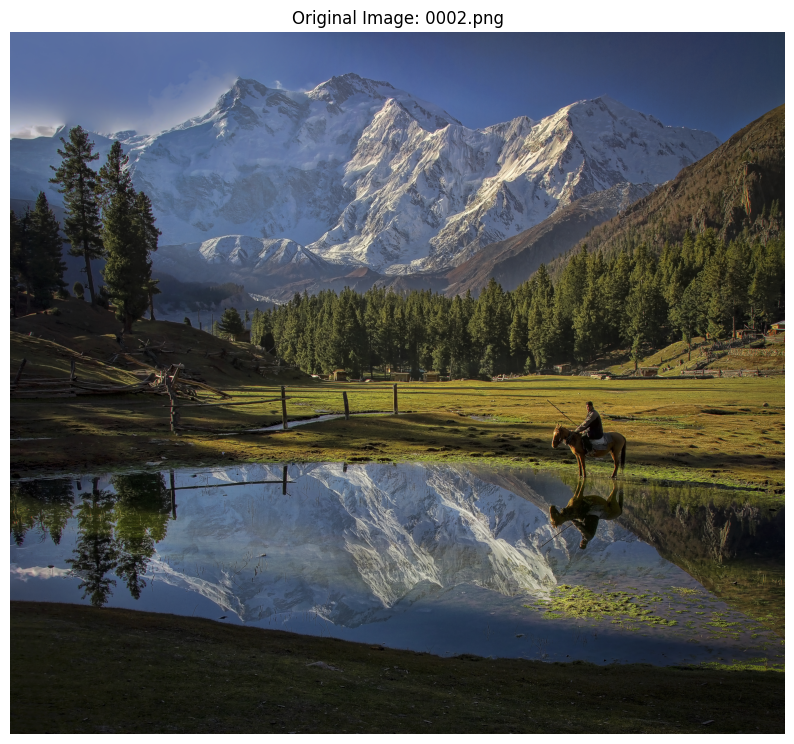

Image dimensions: 1848x2040, 3 channels


In [3]:
img_file_path = image_files[-2]
img_np_original, height_target, width_target, channels = load_image(data_folder, img_file_path)

In [4]:
# Initialize the model
device = torch.device(
    "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
)

print("Currently using device:", device)

Currently using device: mps


In [5]:
# Define the target resolution for the image
H, W = 512, 512  # Adjust as needed

# Create the ImageFitting dataset
dataset = ImageFitting(image_path=os.path.join(data_folder, img_file_path), H=H, W=W)

# Create a DataLoader for the dataset
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

/opt/anaconda3/envs/main/lib/python3.10/site-packages/torch/functional.py:540: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
dataset

## Step 3: Initialize the SIREN Model
The SIREN model is initialized with specific hyperparameters, including the number of hidden layers and the frequency factor (`omega_0`). The model is then moved to the appropriate device (CPU, GPU, or MPS).

In [7]:
# Initialize the Siren model
model = Siren(
    in_features=2,
    hidden_features=256,
    hidden_layers=3,
    out_features=3,
    outermost_linear=True,
    first_omega_0=30,
    hidden_omega_0=30,
)

# Move the model to the appropriate device
model.to(device)

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=3, bias=True)
  )
)

## Step 4: Train the Model
The model is trained using the Adam optimizer. During training, the model learns to map pixel coordinates to their corresponding RGB values. The loss is computed as the mean squared error (MSE) between the predicted and ground truth pixel values.

Every few steps, the reconstructed image is visualized to monitor the training progress.

Training Siren model for 2000 steps with learning rate 0.0001 on device mps
Step 0, Total loss 0.276940


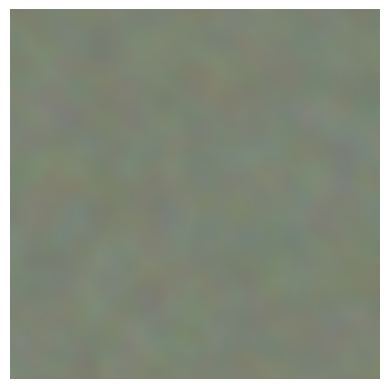

Step 250, Total loss 0.007938


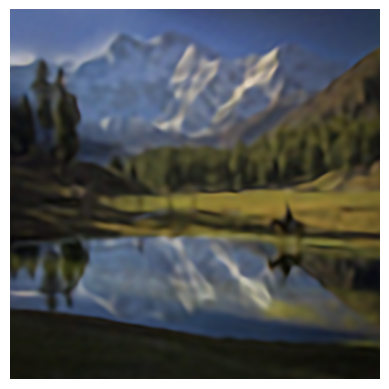

Step 500, Total loss 0.005253


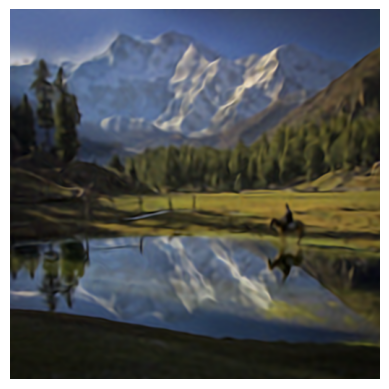

Step 750, Total loss 0.003544


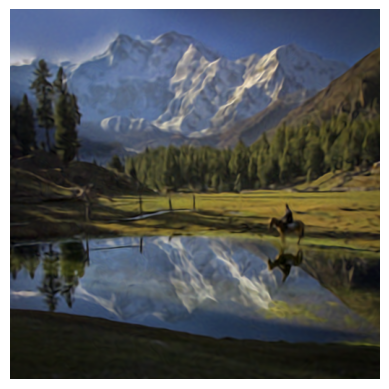

Step 1000, Total loss 0.002499


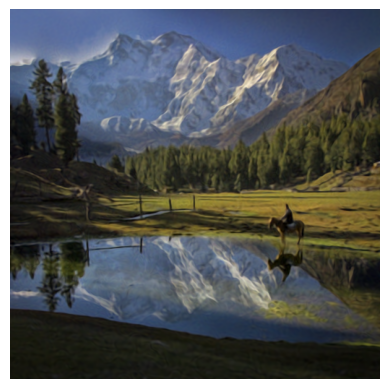

Step 1250, Total loss 0.001869


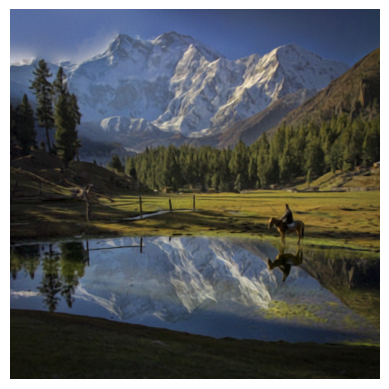

Step 1500, Total loss 0.001498


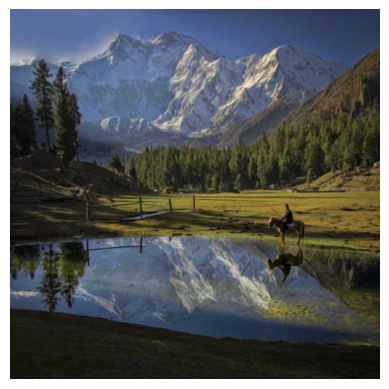

Step 1750, Total loss 0.001223


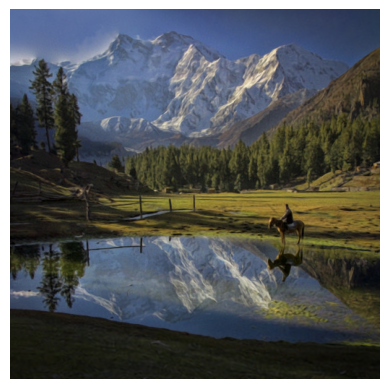

In [8]:
# Initialize a list to track the loss values
losses = []

# Modify the train_siren function to track and save losses
losses = train_siren(
        model=model,
        dataloader=dataloader,
        total_steps=2000,
        steps_til_summary=250,
        lr=1e-4,
        device=device,
        H=H,
        W=W,
)

## Step 5: Plot the Loss Curve
After training, the loss curve can be plotted to visualize the convergence of the model. The loss curve is saved as a NumPy array for later use.

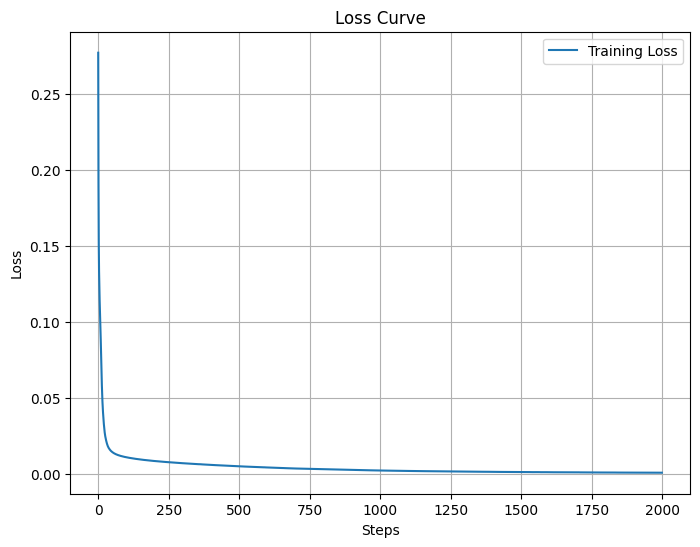

In [9]:
# Load and plot the loss curve
plt.figure(figsize=(8, 6))
plt.plot(range(len(losses)), losses, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid()
plt.show()

# Step 6: Plot the Reconstructed beside the Original Image
Finally, we visualize the original image alongside the reconstructed image generated by the trained SIREN model. This allows us to assess the quality of the reconstruction.

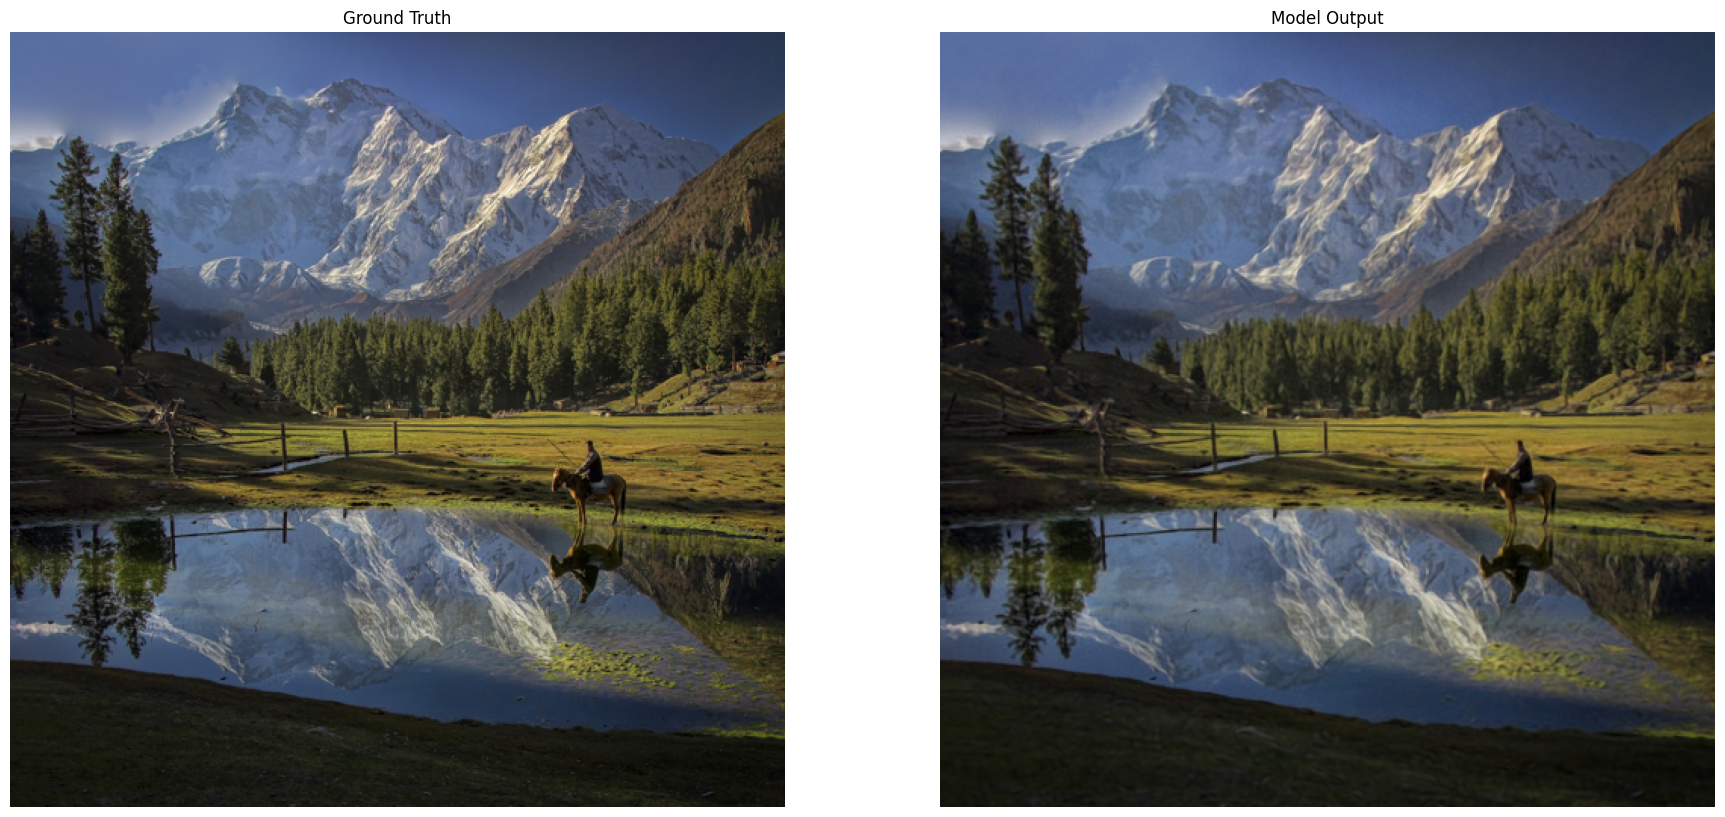

In [10]:
model_input, gt = next(iter(dataloader))
model_input, _ = model_input.to(device), gt.to(device)

img_resized = np.array(Image.fromarray(img_np_original).resize((W, H)))


with torch.no_grad():
    model.eval()
    model_output, coords = model(model_input)  # model_output shape: [1, H*W, 3]
    model_output = model_output.squeeze(0)  # Remove batch dimension, shape: [H*W, 3]
    output_view = model_output.view(H, W, 3)  # Shape: [H, W, 3]
    
    output_view = torch.clamp(output_view, -1, 1) * 0.5 + 0.5
    output_view = (output_view * 255).to(torch.uint8).cpu().detach().numpy()
    
assert output_view.shape == (H, W, 3), f"Output shape mismatch: {output_view.shape}"
assert img_resized.shape == (H, W, 3), f"Image shape mismatch: {img_resized.shape}"
    
# Plot the original image, ground truth side by side
plt.figure(figsize=(22, 12))
plt.subplot(1, 2, 1)
plt.imshow(img_resized)
plt.title("Ground Truth")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(output_view)
plt.title("Model Output")
plt.axis("off")
plt.show()